In [1]:
import os
import pandas as pd
import operator
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Patient Characteristics Survey for the Years 2013, 2015, 2017, 2019, and 2022

### Part 1: Data Understanding and Preparation

In [2]:
# Set the parameters to import PCS data for each survey
current_directory = os.getcwd()
PCS_survey_years = ['2013', '2015', '2017', '2019', '2022']
program_category_data = ['EMERGENCY', 'INPATIENT', 'OUTPATIENT', 'RESIDENTIAL', 'SUPPORT']
survey_name_PCS = 'Patient Characteristics Survey'
dfs_PCS = {}
dfs_program_category = {}

# Import the PCS CSV as a dataframe using file_path
for survey_year in PCS_survey_years:
    file_path = os.path.join(current_directory, survey_name_PCS, survey_year, 'Data',
                             f'modified_NYC_PCS{survey_year}.csv')
    dfs_PCS[f'PCS{survey_year}'] = pd.read_csv(file_path, dtype=str)

    for program_category in program_category_data:
        file_path = os.path.join(current_directory, survey_name_PCS, survey_year, 'Data', 
                                 f'{program_category}.csv')
        dfs_program_category[f'PCS{survey_year}_{program_category}'] = pd.read_csv(file_path, dtype=str)

# Ensure that the values within the PCS dataframes are read as numeric values for analysis
for year, df in dfs_PCS.items():
    dfs_PCS[year] = df.apply(pd.to_numeric, errors='coerce')

# Assign dataframes dynamically to global variables
for year in PCS_survey_years:
    globals()[f'PCS{year}'] = dfs_PCS[f'PCS{year}']
    for program_category in program_category_data:
        globals()[f'PCS{year}_{program_category}'] = dfs_program_category[f'PCS{year}_{program_category}']


In [4]:
all_dfs = {**dfs_PCS, **dfs_program_category}

for dataframe_name, dataframe in all_dfs.items():
    dataframe['Medicaid'] = (
        (dataframe['Medicaid Insurance'] == 1) |
        (dataframe['Medicaid Managed Insurance'] == 1) |
        (dataframe['Medicaid and Medicare Insurance'] == 1)
    ).astype(float)


In [4]:
print('Number of respondents to each Patient Characteristics Survey:')
observation_year = 0
for dataframe_name, dataframe in dfs_PCS.items():
    observations_PCS = len(dataframe)
    print(f'  • Survey Year {PCS_survey_years[observation_year]}:{observations_PCS: ,}')
    observation_year = observation_year + 1

Number of respondents to each Patient Characteristics Survey:
  • Survey Year 2013: 180,204
  • Survey Year 2015: 179,096
  • Survey Year 2017: 175,926
  • Survey Year 2019: 196,102
  • Survey Year 2022: 206,612


In [5]:
print(f'Adult respondents to the Patient Characteristics Survey with SMI:')
observation_year = 0
for dataframe_name, dataframe in dfs_PCS.items():
    observations_PCS = (dataframe['Age Group'] == 0.0).sum()
    count = ((dataframe['Serious Mental Illness'] == 1.0) & (dataframe['Age Group'] == 0.0)).sum()
    total = count / observations_PCS
    print(f'  • Survey Year {PCS_survey_years[observation_year]}: {count:,} out of{observations_PCS: ,} respondents or{total: 0.2%}')
    observation_year = observation_year + 1


Adult respondents to the Patient Characteristics Survey with SMI:
  • Survey Year 2013: 118,044 out of 144,464 respondents or 81.71%
  • Survey Year 2015: 115,869 out of 143,213 respondents or 80.91%
  • Survey Year 2017: 132,670 out of 140,506 respondents or 94.42%
  • Survey Year 2019: 143,255 out of 152,202 respondents or 94.12%
  • Survey Year 2022: 154,802 out of 163,797 respondents or 94.51%


In [6]:
print(f'Adult respondents enrolled in Medicaid:')
for dataframe_name, dataframe in dfs_PCS.items():
    observations_PCS = ((dataframe['Age Group'] == 0.0)).sum()
    count = ((dataframe['Medicaid'] == 1.0) & (dataframe['Age Group'] == 0.0)).sum()
    total = count / observations_PCS
    print(f'  • {dataframe_name}: {count:,} out of{observations_PCS: ,} respondents or{total: 0.2%}')


Adult respondents enrolled in Medicaid:
  • PCS2013: 106,431 out of 144,464 respondents or 73.67%
  • PCS2015: 105,525 out of 143,213 respondents or 73.68%
  • PCS2017: 103,427 out of 140,506 respondents or 73.61%
  • PCS2019: 108,606 out of 152,202 respondents or 71.36%
  • PCS2022: 117,319 out of 163,797 respondents or 71.62%


In [7]:
# return a summary of the total number of respondents, the number with serious mental illness, and the 
# percentage with serious mental illness
variable_of_interest = 'SSI Cash Assistance'
observation_year = 0
print(f'Adult respondents with SMI who receive {variable_of_interest}:')
for dataframe_name, dataframe in dfs_PCS.items():
    observations_PCS = (dataframe['Age Group'] == 0.0).sum()
    count = ((dataframe[variable_of_interest] == 1.0) & (dataframe['Serious Mental Illness'] == 1.0) & (dataframe['Age Group'] == 0.0)).sum()
    total = count / observations_PCS
    print(f'  • Survey Year {PCS_survey_years[observation_year]}: {count:,} of{observations_PCS: ,} respondents or{total: 0.2%}')
    observation_year = observation_year + 1


Adult respondents with SMI who receive SSI Cash Assistance:
  • Survey Year 2013: 59,182 of 144,464 respondents or 40.97%
  • Survey Year 2015: 50,772 of 143,213 respondents or 35.45%
  • Survey Year 2017: 53,983 of 140,506 respondents or 38.42%
  • Survey Year 2019: 51,816 of 152,202 respondents or 34.04%
  • Survey Year 2022: 48,835 of 163,797 respondents or 29.81%


In [8]:
class Summarize_PCS:
    def __init__(self, data, index, column_list, filter_conditions_dict, focus_column):
        self.data = data
        self.index = index
        self.column_list = column_list
        self.filter_conditions_dict = filter_conditions_dict  # Dictionary of filter conditions
        self.focus_column = focus_column
        self.filtered_dfs = self.prepare_dataframes()

    def prepare_dataframes(self):
        """Prepare filtered dataframes for all filter conditions."""
        filtered_dfs = {}
        for key, filter_conditions in self.filter_conditions_dict.items():
            filter_mask = self.create_filter_mask(self.data, filter_conditions)
            df_filtered = self.data[filter_mask][self.column_list].dropna()
            filtered_dfs[key] = df_filtered
        return filtered_dfs

    def create_filter_mask(self, df, filter_conditions):
        """Generate a boolean mask based on filter conditions."""
        filter_mask = True
        for column, value in filter_conditions.items():
            filter_mask &= (df[column] == value)
        return filter_mask

    def summarize(self, df):
        """Summarize a dataframe by the index."""
        index_group = df.groupby(self.index)[self.focus_column].sum().reset_index()
        return index_group

    def share(self, total_type="column", share_base="column"):
        """
        Calculate totals and shares for each filter condition.
        
        Parameters:
            total_type (str): Specify "column" for column totals or "row" for row totals.
            share_base (str): Specify "column" or "row" to calculate share based on column total or row total.
        """
        summaries = {}

        # Calculate summaries and totals for each filter condition
        for key, df in self.filtered_dfs.items():
            summary = self.summarize(df)
            summary[f'Total_{key}'] = summary[self.focus_column].round(0).astype(int)
            summaries[key] = summary

        # Merge all summaries dynamically
        final_summary = None
        for key, summary in summaries.items():
            if final_summary is None:
                final_summary = summary[[self.index, f'Total_{key}']]
            else:
                final_summary = final_summary.merge(
                    summary[[self.index, f'Total_{key}']],
                    on=self.index,
                    how='outer')

        if total_type == "column":
            # Add a column total row
            column_totals = final_summary.sum(numeric_only=True)
            column_totals[self.index] = "Total"
            final_summary = pd.concat([final_summary, pd.DataFrame([column_totals])], ignore_index=True)
        elif total_type == "row":
            # Add a "Total" column for row totals
            final_summary["Total"] = final_summary.filter(like="Total_").sum(axis=1).round(0).astype(int)

        # Calculate shares based on the specified share_base
        if share_base == "column":
            for key in self.filter_conditions_dict.keys():
                column_sum = final_summary.loc[final_summary[self.index] == "Total", f'Total_{key}'].values[0]
                final_summary[f'Share_{key}'] = (
                    final_summary[f'Total_{key}'] / column_sum).round(4)
        elif share_base == "row":
            # Ensure the "Total" column exists for row-based shares
            if "Total" not in final_summary.columns:
                final_summary["Total"] = final_summary.filter(like="Total_").sum(axis=1).round(0).astype(int)
            for key in self.filter_conditions_dict.keys():
                final_summary[f'Share_{key}'] = (
                    final_summary[f'Total_{key}'] / final_summary["Total"]).round(4)

        final_summary = final_summary.set_index(self.index)
        return final_summary

In [9]:
PCS_hours_worked_replace = ['Emergency', 'Inpatient', 'Outpatient', 'Residential', 'Support']

PCS_SMI_hours_worked_results = {}  # dictionary to store results for each year

for year, dataframe in dfs_PCS.items():
    # Parameters to create an instance of the class, Summarize
    data = dataframe
    index = 'Program Category'
    filter_list = [index, 'Serious Mental Illness', 'Employment Status - Employed', 'Age Group']
    filter_conditions = {
        'Condition 1': {'Serious Mental Illness': 1.0, 'Employment Status - Employed': 1.0, 'Age Group': 0.0}, 
        'Condition 2': {'Serious Mental Illness': 1.0, 'Employment Status - Employed': 0.0, 'Age Group': 0.0}}
    focus_column = 'Serious Mental Illness'

    # Create an instance of the class, Summarize, called PCS_SMI_hours_worked
    PCS_SMI_hours_worked = Summarize_PCS(data, index, filter_list, filter_conditions, focus_column)

    # Get shares based on row totals
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.share(total_type="row", share_base="row")

    column_rename_map = {
        'Total_Condition 1': 'Employed Total',
        'Share_Condition 1': 'Employed Share',
        'Total_Condition 2': 'Unemployed Total',
        'Share_Condition 2': 'Unemployed Share'}
    
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.rename(columns=column_rename_map)

    # Replace original values in column, 'Number Of Hours Worked Each Week', with values in PCS_hours_worked_replace
    PCS_SMI_hours_worked[f'{index} Index'] = PCS_hours_worked_replace
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.set_index(f'{index} Index')
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.rename_axis(index)

    title = f'<span style="font-weight: bold; color: black;">Adult Respondents with Serious Mental Illness by Employment Status and Program Category ({year})</span>'
    note = '<span style="color: grey; font-style: italic;">Note: NILF stands for not in labor force</span>'
    styled_PCS_SMI_hours_worked = PCS_SMI_hours_worked.style.set_caption(title)

    # Store the styled result in the dictionary
    PCS_SMI_hours_worked_results[year] = styled_PCS_SMI_hours_worked

    display(styled_PCS_SMI_hours_worked)

,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,191,1471,1662,0.114900,0.885100
Inpatient,652,7100,7752,0.084100,0.915900
Outpatient,10487,54243,64730,0.162000,0.838000
Residential,2455,21633,24088,0.101900,0.898100
Support,2613,14671,17284,0.151200,0.848800


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,240,1462,1702,0.141000,0.859000
Inpatient,586,6344,6930,0.084600,0.915400
Outpatient,12897,54545,67442,0.191200,0.808800
Residential,2441,23134,25575,0.095400,0.904600
Support,1854,9007,10861,0.170700,0.829300


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,389,1612,2001,0.194400,0.805600
Inpatient,730,6727,7457,0.097900,0.902100
Outpatient,19507,58097,77604,0.251400,0.748600
Residential,2900,25105,28005,0.103600,0.896400
Support,2089,11530,13619,0.153400,0.846600


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,391,1520,1911,0.204600,0.795400
Inpatient,774,6544,7318,0.105800,0.894200
Outpatient,24685,59287,83972,0.294000,0.706000
Residential,3003,25756,28759,0.104400,0.895600
Support,1903,10911,12814,0.148500,0.851500


,Employed Total,Unemployed Total,Total,Employed Share,Unemployed Share
Program Category,,,,,
Emergency,342,1345,1687,0.202700,0.797300
Inpatient,643,5616,6259,0.102700,0.897300
Outpatient,32389,63895,96284,0.336400,0.663600
Residential,2719,25519,28238,0.096300,0.903700
Support,1973,9635,11608,0.170000,0.830000


In [10]:
# replace the row names for improved understanding
PCS_employment_status_replace = ['Employed', 'Non-Paid/Volunteer', 'Not in Labor Force',
                                 'Unemployed', 'Total']

PCS_SMI_emp_statuses = {}  # dictionary to store results for each year

for year, dataframe in dfs_PCS.items(): 
    
    # the following parameters are used to create an instance of the class, Summarize.
    data = dataframe
    index = 'Employment Status' # input
    filter_list = [index, 'Serious Mental Illness', 'Medicaid', 'Age Group'] # input
    filter_conditions = {"Condition_1": {'Serious Mental Illness': 1.0, 'Medicaid': 1.0, 'Age Group': 0.0}} # input
    focus_column = 'Serious Mental Illness' # input

    # create an instance of the class, Summarize, called PCS_SMI_emp_status, using the above parameters
    PCS_SMI_emp_status = Summarize_PCS(data, index, filter_list, filter_conditions, focus_column)

    # use the share method to calculate the share of adults with serious mental illness (SMI) enrolled in Medicaid by employment status
    PCS_SMI_emp_status = PCS_SMI_emp_status.share()
    
    # replace original values in column, 'Employment Status' with values in PCS_employment_status_replace
    PCS_SMI_emp_status[f'{index} Index'] = PCS_employment_status_replace
    
    PCS_SMI_emp_status = PCS_SMI_emp_status.set_index(f'{index} Index')
    PCS_SMI_emp_status = PCS_SMI_emp_status.rename_axis(index)
    
    title = f'<span style="font-weight: bold; color: black;">Respondents to the Patient Characteristics Survey with Serious Mental Illness Enrolled in Medicaid by Employment Status, {year}</span>'
    note = '<span style="color: grey; font-style: italic;">Note: Adults include residents of New York between the ages 19 and 64</span>'
    PCS_SMI_emp_status = PCS_SMI_emp_status.style.set_caption(title + "<br>" + note)

    # store result in the dictionary accessible through the command, display
    PCS_SMI_emp_statuses[year] = PCS_SMI_emp_status
    display(PCS_SMI_emp_status)
    

,Total_Condition_1,Share_Condition_1
Employment Status,,
Employed,10204.000000,0.112200
Non-Paid/Volunteer,1578.000000,0.017400
Not in Labor Force,67088.000000,0.737700
Unemployed,12068.000000,0.132700
Total,90938.000000,1.000000


,Total_Condition_1,Share_Condition_1
Employment Status,,
Employed,11482.000000,0.130600
Non-Paid/Volunteer,1217.000000,0.013800
Not in Labor Force,63792.000000,0.725400
Unemployed,11444.000000,0.130100
Total,87935.000000,1.000000


,Total_Condition_1,Share_Condition_1
Employment Status,,
Employed,15565.000000,0.159900
Non-Paid/Volunteer,1446.000000,0.014900
Not in Labor Force,66497.000000,0.683100
Unemployed,13836.000000,0.142100
Total,97344.000000,1.000000


,Total_Condition_1,Share_Condition_1
Employment Status,,
Employed,17520.000000,0.177300
Non-Paid/Volunteer,1329.000000,0.013400
Not in Labor Force,64263.000000,0.650200
Unemployed,15727.000000,0.159100
Total,98839.000000,1.000000


,Total_Condition_1,Share_Condition_1
Employment Status,,
Employed,22884.000000,0.215600
Non-Paid/Volunteer,784.000000,0.007400
Not in Labor Force,67113.000000,0.632300
Unemployed,15359.000000,0.144700
Total,106140.000000,1.000000


In [11]:
PCS_hours_worked_replace = ['Unemployed/NILF', '01-14 HOURS', '15-34 HOURS', '>= 35 HOURS', 'Total']

PCS_SMI_hours_worked_results = {}  # dictionary to store results for each year

for year, dataframe in dfs_PCS.items():
    
    # the following parameters are used to create an instance of the class, Summarize.
    data = dataframe
    index = 'Number Of Hours Worked Each Week'
    column_list = [index, 'Serious Mental Illness', 'Medicaid Insurance', 'Age Group']
    filter_list = {'Serious Mental Illness': 1.0, 'Medicaid Insurance': 1.0, 'Age Group': 0.0}
    focus_column = 'Serious Mental Illness'

    # create an instance of the class, Summarize, called PCS_SMI_hours_worked
    PCS_SMI_hours_worked = Summarize_PCS(data, index, column_list, filter_conditions, focus_column)
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.share()

    # replace original values in column, 'Number Of Hours Worked Each Week', with values in PCS_hours_worked_replace
    PCS_SMI_hours_worked[f'{index} Index'] = PCS_hours_worked_replace
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.set_index(f'{index} Index')
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.rename_axis(index)

    title = f'<span style="font-weight: bold; color: black;">Respondents to the Patient Characteristics Survey with Serious Mental Illness Enrolled in Medicaid by Employment Status, {year}</span>'
    note = '<span style="color: grey; font-style: italic;">Note: NILF stands for not in labor force</span>'
    styled_PCS_SMI_hours_worked = PCS_SMI_hours_worked.style.set_caption(title + "<br>" + note)

    # store the styled result in the dictionary
    PCS_SMI_hours_worked_results[year] = styled_PCS_SMI_hours_worked
    
    display(styled_PCS_SMI_hours_worked)


,Total_Condition_1,Share_Condition_1
Number Of Hours Worked Each Week,,
Unemployed/NILF,79156.000000,0.895300
01-14 HOURS,3136.000000,0.035500
15-34 HOURS,4555.000000,0.051500
>= 35 HOURS,1568.000000,0.017700
Total,88415.000000,1.000000


,Total_Condition_1,Share_Condition_1
Number Of Hours Worked Each Week,,
Unemployed/NILF,75236.000000,0.879600
01-14 HOURS,3076.000000,0.036000
15-34 HOURS,4893.000000,0.057200
>= 35 HOURS,2326.000000,0.027200
Total,85531.000000,1.000000


,Total_Condition_1,Share_Condition_1
Number Of Hours Worked Each Week,,
Unemployed/NILF,80333.000000,0.859700
01-14 HOURS,3316.000000,0.035500
15-34 HOURS,6117.000000,0.065500
>= 35 HOURS,3674.000000,0.039300
Total,93440.000000,1.000000


,Total_Condition_1,Share_Condition_1
Number Of Hours Worked Each Week,,
Unemployed/NILF,79990.000000,0.836800
01-14 HOURS,3794.000000,0.039700
15-34 HOURS,7009.000000,0.073300
>= 35 HOURS,4794.000000,0.050200
Total,95587.000000,1.000000


,Total_Condition_1,Share_Condition_1
Number Of Hours Worked Each Week,,
Unemployed/NILF,82472.000000,0.809600
01-14 HOURS,3739.000000,0.036700
15-34 HOURS,8001.000000,0.078500
>= 35 HOURS,7650.000000,0.075100
Total,101862.000000,1.000000


In [12]:
SSI_replace = ['Receives SSI', 'Does Not Receive SSI', 'Total']

SSI_results = {}  # dictionary to store results for each year

for year, dataframe in dfs_PCS.items():
    
    # the following parameters are used to create an instance of the class, Summarize.
    data = dataframe
    index = 'SSI Cash Assistance'
    column_list = [index, 'Serious Mental Illness', 'Medicaid Insurance', 'Age Group']
    
    # Convert filter_conditions into a dictionary of dictionaries to match expected format
    filter_conditions_dict = {'filter_set_1': {'Serious Mental Illness': 1.0, 'Medicaid Insurance': 1.0, 'Age Group': 0.0}}
    
    focus_column = 'Serious Mental Illness'

    # create an instance of the class, Summarize, called PCS_SMI_hours_worked
    PCS_SMI_hours_worked = Summarize_PCS(data, index, column_list, filter_conditions_dict, focus_column)
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.share()

    # replace original values in column, 'Number Of Hours Worked Each Week', with values in PCS_hours_worked_replace
    PCS_SMI_hours_worked[f'{index} Index'] = SSI_replace
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.set_index(f'{index} Index')
    PCS_SMI_hours_worked = PCS_SMI_hours_worked.rename_axis(index)

    title = f'<span style="font-weight: bold; color: black;">Respondents to the Patient Characteristics Survey with Serious Mental Illness Enrolled in Medicaid by Employment Status, {year}</span>'
    note = '<span style="color: grey; font-style: italic;">Note: NILF stands for not in labor force</span>'
    styled_PCS_SMI_hours_worked = PCS_SMI_hours_worked.style.set_caption(title + "<br>" + note)

    # store the styled result in the dictionary
    SSI_results[year] = styled_PCS_SMI_hours_worked
    
    display(styled_PCS_SMI_hours_worked)

,Total_filter_set_1,Share_filter_set_1
SSI Cash Assistance,,
Receives SSI,33443.000000,0.374700
Does Not Receive SSI,55816.000000,0.625300
Total,89259.000000,1.000000


,Total_filter_set_1,Share_filter_set_1
SSI Cash Assistance,,
Receives SSI,37534.000000,0.442700
Does Not Receive SSI,47258.000000,0.557300
Total,84792.000000,1.000000


,Total_filter_set_1,Share_filter_set_1
SSI Cash Assistance,,
Receives SSI,43186.000000,0.462700
Does Not Receive SSI,50147.000000,0.537300
Total,93333.000000,1.000000


,Total_filter_set_1,Share_filter_set_1
SSI Cash Assistance,,
Receives SSI,47151.000000,0.496800
Does Not Receive SSI,47760.000000,0.503200
Total,94911.000000,1.000000


,Total_filter_set_1,Share_filter_set_1
SSI Cash Assistance,,
Receives SSI,54019.000000,0.547200
Does Not Receive SSI,44698.000000,0.452800
Total,98717.000000,1.000000


## Part 3: Instrumental Variable Regression

In [13]:
dfs_PCS_IV = {}

for survey_year in PCS_survey_years:
    dfs_PCS_IV[f'PCS{survey_year}_IV'] = dfs_PCS[f'PCS{survey_year}'].copy()
    if survey_year == '2013':
            dfs_PCS_IV[f'PCS2013_IV'].rename(columns={'Educational Status': 'Education Status'}, inplace=True)
    globals()[f'PCS{survey_year}_IV'] = dfs_PCS[f'PCS{survey_year}'].copy()



In [14]:
for dataframe_name, dataframe in dfs_PCS.items():
    drop_indices = dataframe[(dataframe['Age Group'] == 1.0) 
                             | dataframe['Employment Status'].isna() 
                             | dataframe['Serious Mental Illness'].isna()].index
    dataframe.drop(index=drop_indices, inplace=True)
    globals()[dataframe_name] = dataframe


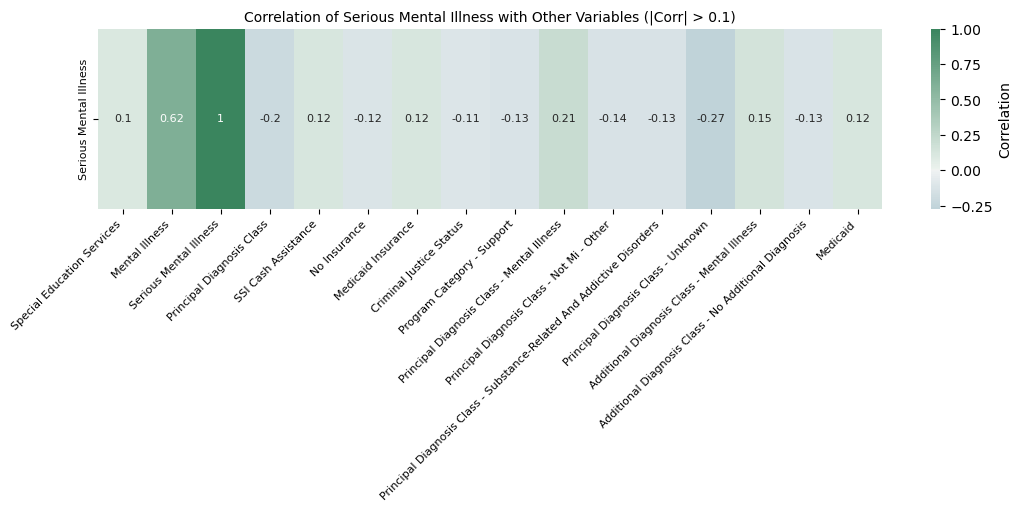

In [15]:
# Set correlation cutoff
cutoff = 0.1

# Calculate correlations and filter based on cutoff
SMI_corr = PCS2019.corr()[['Serious Mental Illness']].transpose()  # Transpose for horizontal heatmap
filtered_SMI_corr = SMI_corr.loc[:, (SMI_corr.abs() > cutoff).any(axis=0)]  # Keep only correlations above cutoff

cmap = sns.diverging_palette(220, 145, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(14, 4))  # Smaller figure size
sns.heatmap(filtered_SMI_corr, 
            annot=True, 
            cmap=cmap, 
            cbar_kws={'label': 'Correlation'}, 
            center = 0,
            xticklabels=filtered_SMI_corr.columns, 
            yticklabels=['Serious Mental Illness'],
            annot_kws={"size": 8})  # Smaller annotation font size

plt.title(f'Correlation of Serious Mental Illness with Other Variables (|Corr| > {cutoff})', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Smaller x-tick font size
plt.yticks(fontsize=8)  # Smaller y-tick font size

# Adjust margins to prevent cut-off
plt.subplots_adjust(left=0.2, right=0.9, top=0.85, bottom=0.4)

plt.show()


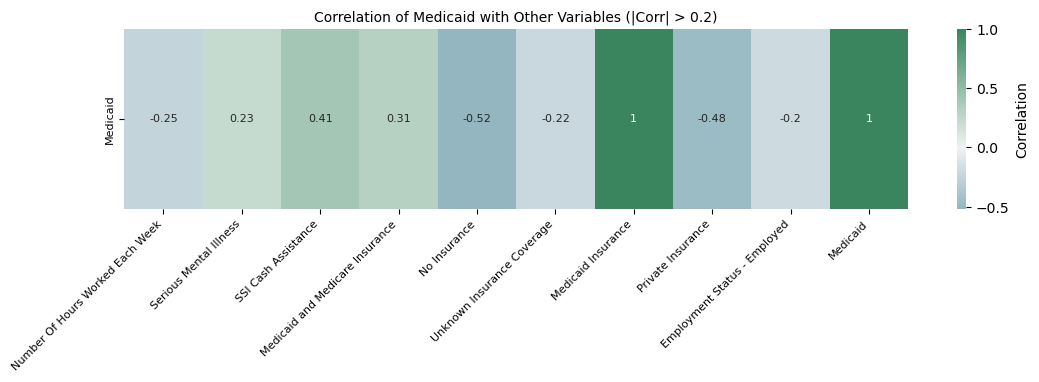

In [16]:
# Set correlation cutoff
cutoff = 0.2

# Calculate correlations and filter based on cutoff
medicaid_corr = PCS2013.corr()[['Medicaid']].transpose()  # Transpose for horizontal heatmap
filtered_corr = medicaid_corr.loc[:, (medicaid_corr.abs() > cutoff).any(axis=0)]  # Keep only correlations above cutoff

cmap = sns.diverging_palette(220, 145, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(14, 4))  # Smaller figure size
sns.heatmap(filtered_corr, 
            annot=True, 
            cmap=cmap, 
            cbar_kws={'label': 'Correlation'}, 
            center = 0,
            xticklabels=filtered_corr.columns, 
            yticklabels=['Medicaid'],
            annot_kws={"size": 8})  # Smaller annotation font size

plt.title(f'Correlation of Medicaid with Other Variables (|Corr| > {cutoff})', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Smaller x-tick font size
plt.yticks(fontsize=8)  # Smaller y-tick font size

# Adjust margins to prevent cut-off
plt.subplots_adjust(left=0.2, right=0.9, top=0.85, bottom=0.4)

plt.show()


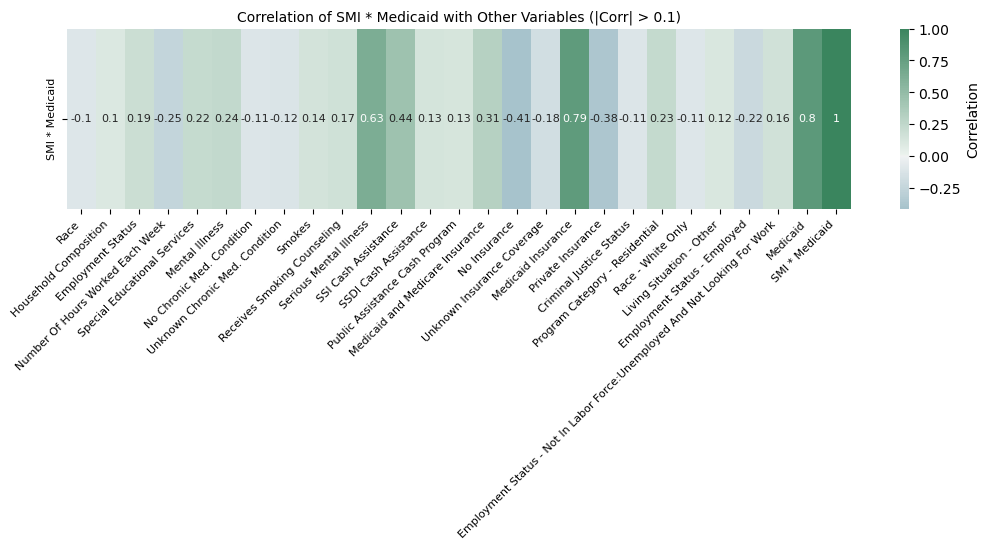

In [17]:
for year, df in dfs_PCS.items():
    dfs_PCS[year]['SMI * Medicaid'] = dfs_PCS[year]['Serious Mental Illness'] * dfs_PCS[year]['Medicaid']
    globals()[f'{year}'] = dfs_PCS[f'{year}']

# Set correlation cutoff
cutoff = 0.1

# Calculate correlations and filter based on cutoff
SMI_Medicaid_corr = PCS2013.corr()[['SMI * Medicaid']].transpose()  # Transpose for horizontal heatmap
filtered_SMI_Medicaid_corr = SMI_Medicaid_corr.loc[:, (SMI_Medicaid_corr.abs() > cutoff).any(axis=0)]  # Keep only correlations above cutoff

cmap = sns.diverging_palette(220, 145, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(14, 4))  # Smaller figure size
sns.heatmap(filtered_SMI_Medicaid_corr, 
            annot=True, 
            cmap=cmap, 
            cbar_kws={'label': 'Correlation'}, 
            center = 0,
            xticklabels=filtered_SMI_Medicaid_corr.columns, 
            yticklabels=['SMI * Medicaid'],
            annot_kws={"size": 8})  # Smaller annotation font size

plt.title(f'Correlation of SMI * Medicaid with Other Variables (|Corr| > {cutoff})', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Smaller x-tick font size
plt.yticks(fontsize=8)  # Smaller y-tick font size

# Adjust margins to prevent cut-off
plt.subplots_adjust(left=0.2, right=0.9, top=0.85, bottom=0.4)

plt.show()


In [24]:
filtered_SMI_Medicaid_corr_columns = list(filtered_SMI_Medicaid_corr.columns)
PCS2013[filtered_SMI_Medicaid_corr_columns]

,Race,Household Composition,Employment Status,Number Of Hours Worked Each Week,Special Educational Services,Mental Illness,No Chronic Med. Condition,Unknown Chronic Med. Condition,Smokes,Receives Smoking Counseling,...,Medicaid Insurance,Private Insurance,Criminal Justice Status,Program Category - Residential,Race - White Only,Living Situation - Other,Employment Status - Employed,Employment Status - Not In Labor Force:Unemployed And Not Looking For Work,Medicaid,SMI * Medicaid
1,2.0,0.0,0.0,3.0,NaN,1.0,0.0,0,0.0,0,...,0.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,3.0,0.0,NaN,1.0,0.0,0,NaN,0,...,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.0,0.0,2.0,0.0,NaN,1.0,0.0,0,0.0,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0
5,3.0,0.0,2.0,0.0,NaN,1.0,1.0,0,1.0,0,...,1.0,0.0,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0
6,3.0,1.0,2.0,0.0,NaN,1.0,0.0,0,1.0,0,...,1.0,0.0,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180199,3.0,1.0,1.0,NaN,NaN,1.0,0.0,0,0.0,0,...,1.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,1.0
180200,3.0,1.0,2.0,0.0,NaN,1.0,0.0,0,1.0,0,...,1.0,1.0,0.0,1,1.0,0.0,0.0,1.0,1.0,1.0
180201,0.0,1.0,0.0,3.0,NaN,1.0,0.0,0,NaN,0,...,0.0,1.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0
180202,3.0,NaN,1.0,NaN,NaN,1.0,0.0,0,0.0,0,...,1.0,0.0,0.0,0,1.0,1.0,0.0,0.0,1.0,1.0
